In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings

import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [6]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'WenQuanYi Zen Hei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [7]:
# help(pd.read_csv)

In [8]:
pd.read_csv("datas/crx.data", header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


In [9]:
### 加载数据并对数据进行预处理
# 1. 加载数据
path = "datas/crx.data"
names = ['A1','A2','A3','A4','A5','A6','A7','A8',
         'A9','A10','A11','A12','A13','A14','A15','A16']
df = pd.read_csv(path, header=None, names=names)
print ("数据条数:", len(df))

# 2. 异常数据过滤
df = df.replace("?", np.nan).dropna(how='any')
print ("过滤后数据条数:", len(df))

df.head(5)

数据条数: 690
过滤后数据条数: 653


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [10]:
df.info() # 看一下各个列的字符相关信息

<class 'pandas.core.frame.DataFrame'>
Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      653 non-null    object 
 1   A2      653 non-null    object 
 2   A3      653 non-null    float64
 3   A4      653 non-null    object 
 4   A5      653 non-null    object 
 5   A6      653 non-null    object 
 6   A7      653 non-null    object 
 7   A8      653 non-null    float64
 8   A9      653 non-null    object 
 9   A10     653 non-null    object 
 10  A11     653 non-null    int64  
 11  A12     653 non-null    object 
 12  A13     653 non-null    object 
 13  A14     653 non-null    object 
 14  A15     653 non-null    int64  
 15  A16     653 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.7+ KB


In [11]:
# TODO: 有没有其它便捷的代码一次性查看所有的数据类型为object的取值信息
df.A16.value_counts()

A16
-    357
+    296
Name: count, dtype: int64

In [12]:
# 自定义的一个哑编码实现方式：将v变量转换成为一个向量/list集合的形式
def parse(v, l):
    # v是一个字符串，需要进行转换的数据
    # l是一个类别信息，其中v是其中的一个值
    return [1 if i == v else 0 for i in l]
# 定义一个处理每条数据的函数
def parseRecord(record):
    result = []
    ## 格式化数据，将离散数据转换为连续数据
    a1 = record['A1']
    for i in parse(a1, ('a', 'b')):
        result.append(i)
    
    result.append(float(record['A2']))
    result.append(float(record['A3']))
    
    # 将A4的信息转换为哑编码的形式; 对于DataFrame中，原来一列的数据现在需要四列来进行表示
    a4 = record['A4']
    for i in parse(a4, ('u', 'y', 'l', 't')):
        result.append(i)
    
    a5 = record['A5']
    for i in parse(a5, ('g', 'p', 'gg')):
        result.append(i)
    
    a6 = record['A6']
    for i in parse(a6, ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')):
        result.append(i)
    
    a7 = record['A7']
    for i in parse(a7, ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')):
        result.append(i)
    
    result.append(float(record['A8']))
    
    a9 = record['A9']
    for i in parse(a9, ('t', 'f')):
        result.append(i)
        
    a10 = record['A10']
    for i in parse(a10, ('t', 'f')):
        result.append(i)
    
    result.append(float(record['A11']))
    
    a12 = record['A12']
    for i in parse(a12, ('t', 'f')):
        result.append(i)
        
    a13 = record['A13']
    for i in parse(a13, ('g', 'p', 's')):
        result.append(i)
    
    result.append(float(record['A14']))
    result.append(float(record['A15']))
    
    a16 = record['A16']
    if a16 == '+':
        result.append(1)
    else:
        result.append(0)
        
    return result

In [13]:
# 哑编码实验
print(parse('v', ['v', 'y', 'l']))
print(parse('y', ['v', 'y', 'l']))
print(parse('l', ['v', 'y', 'l']))

[1, 0, 0]
[0, 1, 0]
[0, 0, 1]


In [14]:
### 数据特征处理(将数据转换为数值类型的)
new_names =  ['A1_0', 'A1_1',
              'A2','A3',
              'A4_0','A4_1','A4_2','A4_3', # 因为需要对A4进行哑编码操作，需要使用四列来表示一列的值
              'A5_0', 'A5_1', 'A5_2', 
              'A6_0', 'A6_1', 'A6_2', 'A6_3', 'A6_4', 'A6_5', 'A6_6', 'A6_7', 'A6_8', 'A6_9', 'A6_10', 'A6_11', 'A6_12', 'A6_13', 
              'A7_0', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 
              'A8',
              'A9_0', 'A9_1' ,
              'A10_0', 'A10_1',
              'A11',
              'A12_0', 'A12_1',
              'A13_0', 'A13_1', 'A13_2',
              'A14','A15','A16']
datas = df.apply(lambda x: pd.Series(parseRecord(x), index = new_names), axis=1)
names = new_names

## 展示一下处理后的数据
datas.head(5)

,A1_0,A1_1,A2,A3,A4_0,A4_1,A4_2,A4_3,A5_0,A5_1,...,A10_1,A11,A12_0,A12_1,A13_0,A13_1,A13_2,A14,A15,A16
0,0.0,1.0,30.83,0.000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,202.0,0.0,1.0
1,1.0,0.0,58.67,4.460,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,6.0,0.0,1.0,1.0,0.0,0.0,43.0,560.0,1.0
2,1.0,0.0,24.50,0.500,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,280.0,824.0,1.0
3,0.0,1.0,27.83,1.540,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,1.0,0.0,1.0,0.0,0.0,100.0,3.0,1.0
4,0.0,1.0,20.17,5.625,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.0,1.0


In [15]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 653 entries, 0 to 689
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1_0    653 non-null    float64
 1   A1_1    653 non-null    float64
 2   A2      653 non-null    float64
 3   A3      653 non-null    float64
 4   A4_0    653 non-null    float64
 5   A4_1    653 non-null    float64
 6   A4_2    653 non-null    float64
 7   A4_3    653 non-null    float64
 8   A5_0    653 non-null    float64
 9   A5_1    653 non-null    float64
 10  A5_2    653 non-null    float64
 11  A6_0    653 non-null    float64
 12  A6_1    653 non-null    float64
 13  A6_2    653 non-null    float64
 14  A6_3    653 non-null    float64
 15  A6_4    653 non-null    float64
 16  A6_5    653 non-null    float64
 17  A6_6    653 non-null    float64
 18  A6_7    653 non-null    float64
 19  A6_8    653 non-null    float64
 20  A6_9    653 non-null    float64
 21  A6_10   653 non-null    float64
 22  A6_11  

In [16]:
## 数据分割
X = datas[names[0:-1]]
Y = datas[names[-1]]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)

In [17]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
A1_0,587.0,0.315162,0.464977,0.00,0.000,0.00,1.000,1.00
A1_1,587.0,0.684838,0.464977,0.00,0.000,1.00,1.000,1.00
A2,587.0,31.685417,11.883506,13.75,22.625,28.67,38.290,76.75
A3,587.0,4.909319,5.073588,0.00,1.040,3.00,7.520,28.00
A4_0,587.0,0.761499,0.426530,0.00,1.000,1.00,1.000,1.00
A4_1,587.0,0.235094,0.424419,0.00,0.000,0.00,0.000,1.00
A4_2,587.0,0.003407,0.058321,0.00,0.000,0.00,0.000,1.00
A4_3,587.0,0.000000,0.000000,0.00,0.000,0.00,0.000,0.00
A5_0,587.0,0.761499,0.426530,0.00,1.000,1.00,1.000,1.00
A5_1,587.0,0.235094,0.424419,0.00,0.000,0.00,0.000,1.00


In [18]:
## 数据正则化操作(归一化)
ss = StandardScaler()
## 模型训练一定是在训练集合上训练的
X_train = ss.fit_transform(X_train) ## 训练正则化模型，并将训练数据归一化操作
X_test = ss.transform(X_test) ## 使用训练好的模型对测试数据进行归一化操作

In [19]:
pd.DataFrame(X_train).describe().T

,count,mean,std,min,25%,50%,75%,max
0,587.0,-6.808864e-17,1.000853,-0.678380,-0.678380,-0.678380,1.474101,1.474101
1,587.0,6.808864e-17,1.000853,-1.474101,-1.474101,0.678380,0.678380,0.678380
2,587.0,6.475986e-16,1.000853,-1.510557,-0.763087,-0.253965,0.556251,3.795430
3,587.0,1.906482e-16,1.000853,-0.968448,-0.763290,-0.376646,0.515002,4.555036
4,587.0,-9.229793e-17,1.000853,-1.786857,0.559642,0.559642,0.559642,0.559642
5,587.0,6.354939e-17,1.000853,-0.554391,-0.554391,-0.554391,-0.554391,1.803780
6,587.0,0.000000e+00,1.000853,-0.058471,-0.058471,-0.058471,-0.058471,17.102631
7,587.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,587.0,-9.229793e-17,1.000853,-1.786857,0.559642,0.559642,0.559642,0.559642
9,587.0,6.354939e-17,1.000853,-0.554391,-0.554391,-0.554391,-0.554391,1.803780


In [20]:
## Logistic算法模型构建
# LogisticRegression中，参数说明：
# penalty => 惩罚项方式，即使用何种方式进行正则化操作(可选: l1或者l2)
# C => 惩罚项系数，即L1或者L2正则化项中给定的那个λ系数(ppt上)
# LogisticRegressionCV中，参数说明：
# LogisticRegressionCV表示LogisticRegression进行交叉验证选择超参数(惩罚项系数C/λ)
# Cs => 表示惩罚项系数的可选范围
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='ovr')
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
                     multi_class='ovr', tol=0.01)

In [21]:
## Logistic算法效果输出
lr_r = lr.score(X_train, Y_train)
print ("Logistic算法R值（训练集上的准确率）：", lr_r)
print ("Logistic算法稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print ("Logistic算法参数：",lr.coef_)
print ("Logistic算法截距：",lr.intercept_)

Logistic算法R值（训练集上的准确率）： 0.889267461669506
Logistic算法稀疏化特征比率：2.13%
Logistic算法参数： [[-0.00360566  0.00360566  0.06010294  0.06371679  0.038181   -0.04657456
   0.05970023  0.          0.038181   -0.04657456  0.05970023  0.00424491
  -0.02703857  0.09527565 -0.09250279 -0.01900214 -0.05327403 -0.01117224
   0.0120337   0.04677697  0.03154771  0.12295968  0.03342162 -0.02160594
  -0.10700193 -0.00572481  0.07653215 -0.02175103  0.0248417   0.02830086
  -0.00776041 -0.00740624 -0.09594935 -0.00219562  0.14746233  0.42879631
  -0.42879631  0.15905789 -0.15905789  0.17539052 -0.00924079  0.00924079
   0.01346844 -0.00498746 -0.01266428 -0.0760682   0.11441961]]
Logistic算法截距： [-0.24652859]


In [22]:
## Logistic算法预测（预测所属类别）
lr_y_predict = lr.predict(X_test)
lr_y_predict

array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.])

In [23]:
## Logistic算法获取概率值(就是Logistic算法计算出来的结果值)
y1 = lr.predict_proba(X_test)
y1

array([[0.24518132, 0.75481868],
       [0.20296202, 0.79703798],
       [0.17178695, 0.82821305],
       [0.85700566, 0.14299434],
       [0.48459474, 0.51540526],
       [0.07090791, 0.92909209],
       [0.73535407, 0.26464593],
       [0.24783663, 0.75216337],
       [0.8723624 , 0.1276376 ],
       [0.35539098, 0.64460902],
       [0.07297912, 0.92702088],
       [0.89958974, 0.10041026],
       [0.8374802 , 0.1625198 ],
       [0.17939968, 0.82060032],
       [0.46807905, 0.53192095],
       [0.83317309, 0.16682691],
       [0.15714455, 0.84285545],
       [0.55877825, 0.44122175],
       [0.92300903, 0.07699097],
       [0.22016579, 0.77983421],
       [0.94481245, 0.05518755],
       [0.88258149, 0.11741851],
       [0.85333783, 0.14666217],
       [0.7613708 , 0.2386292 ],
       [0.79653638, 0.20346362],
       [0.67970899, 0.32029101],
       [0.79883456, 0.20116544],
       [0.468032  , 0.531968  ],
       [0.27928182, 0.72071818],
       [0.83752152, 0.16247848],
       [0.

In [24]:
## KNN算法构建
knn = KNeighborsClassifier(n_neighbors=20, algorithm='kd_tree', weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, weights='distance')

In [25]:
## KNN算法效果输出
knn_r = knn.score(X_train, Y_train)
print("Logistic算法训练上R值（准确率）：%.2f" % knn_r)

Logistic算法训练上R值（准确率）：1.00


In [26]:
## KNN算法预测
knn_y_predict = knn.predict(X_test)
knn_r_test = knn.score(X_test, Y_test)
print("Logistic算法训练上R值（测试集上准确率）：%.2f" % knn_r_test)

Logistic算法训练上R值（测试集上准确率）：0.83


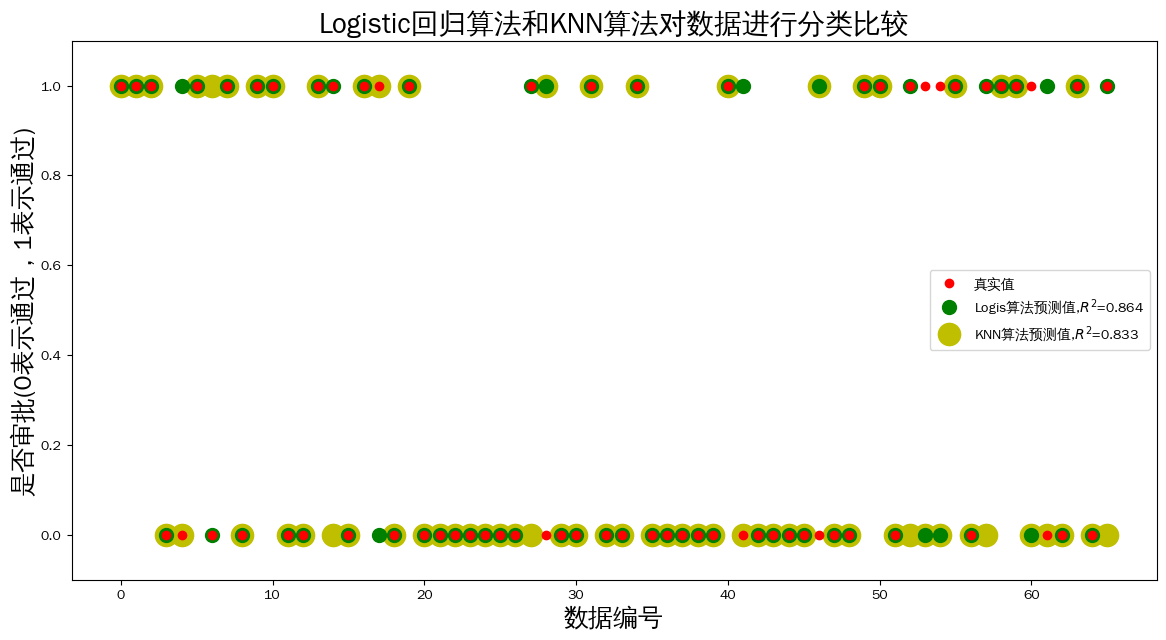

In [27]:
## 结果图像展示
## c. 图表展示
x_len = range(len(X_test))
plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-0.1,1.1)
plt.plot(x_len, Y_test, 'ro',markersize = 6, zorder=3, label=u'真实值')
plt.plot(x_len, lr_y_predict, 'go', markersize = 10, zorder=2, label=u'Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label=u'KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'center right')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'是否审批(0表示通过，1表示通过)', fontsize=18)
plt.title(u'Logistic回归算法和KNN算法对数据进行分类比较', fontsize=20)
plt.show()